# EEG Demo

## Stimuli

https://naturalscenesdataset.org

(downsampled) examples:

![sample1](demo_eeg_data/shared0140_nsd11797.png)
![sample2](demo_eeg_data/shared0936_nsd67830.png)
![sample3](demo_eeg_data/shared0944_nsd68742.png)

## imports

install mne

In [1]:
%matplotlib inline
from os.path import join, expanduser, basename
import glob, json
import numpy, tqdm, mne, pandas
import rsatoolbox
from sklearn.preprocessing import MinMaxScaler
from numpy import atleast_2d
from scipy.spatial.distance import pdist
from matplotlib import pyplot
mne.set_log_level(verbose='error')
demo_data_dir = './demo_eeg_data/'

## Preprocess data

Here we preprocess the EEG data, by looping over the runs, 
reading in the bdf raw data file, applying a band pass filter,
setting a new reference (from electrodes on the mastoids) and epoching
the trials.

In [2]:
rawdata = expanduser('~/data/imasem/rawdata')
derivdata = expanduser('~/data/imasemrsa/epochs')

fpaths = glob.glob(join(rawdata, '**/*_eeg.bdf'), recursive=True)
all_epochs = []
for fpath in tqdm.tqdm(fpaths, smoothing=0):
    raw = mne.io.read_raw_bdf(fpath, preload=True)
    chans_fpath = fpath.replace('_eeg.bdf', '_channels.tsv')
    chans_df = pandas.read_csv(chans_fpath, sep='\t')

    # drop unused channels
    misc_chans = chans_df[chans_df.type=='MISC'].name.to_list()
    raw = raw.drop_channels(misc_chans)

    # filter
    raw = raw.filter(l_freq=0.1, h_freq=40)

    # rereference
    ref_chans = chans_df[chans_df.type=='REF'].name.to_list()
    raw.set_eeg_reference(ref_channels=ref_chans)

    # TODO: add nsd labels in event dict?
    events = mne.find_events(raw)
    eeg_chans = chans_df[chans_df.type=='EEG'].name.to_list()
    epochs = mne.Epochs(
        raw,
        events,
        decim=8,
        tmin=-0.2,
        tmax=+1.0,
        picks=eeg_chans,
        verbose='error'
    )
    fname = basename(fpath.replace('_eeg.bdf', '_epo.fif'))
    epochs.save(join(derivdata, fname))
    all_epochs.append(epochs)

0it [00:00, ?it/s]


## Event-Related Potential
To give you an idea of what the data looks like at this point, here's an ERP plot

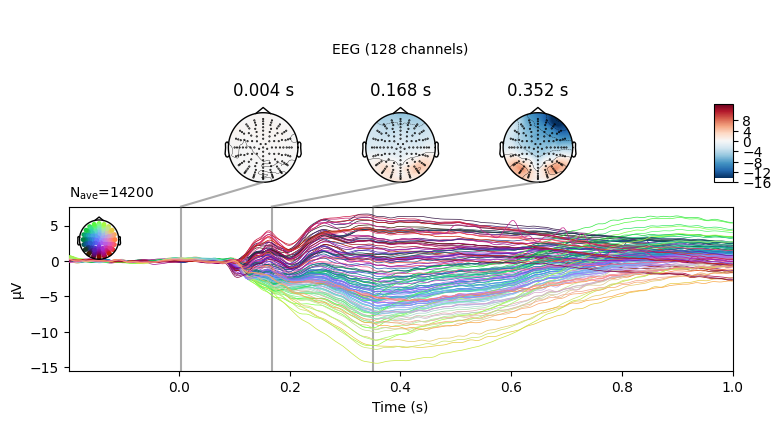

In [8]:
epoch_fpaths = glob.glob(join(derivdata, '*_epo.fif'))
all_epochs = [mne.read_epochs(fpath) for fpath in epoch_fpaths]
grand_avg = mne.concatenate_epochs(all_epochs).average()
grand_avg.set_montage(mne.channels.make_standard_montage('biosemi128'))
grand_avg.plot_joint()
pyplot.close()

## Importing the data to rsatoolbox

This is where the rsatoolbox library comes into play.
We use the rsatoolbox function `io.mne.read_epochs` to load each individual run,
then merge them per subject

In [5]:
## loading the epoched data into rsatoolbox
sub = 1
runs = []
for fpath in glob.glob(join(epochs_data_dir, f'sub-0{sub}*task-images*.fif')):
    runs.append(rsatoolbox.io.mne.read_epochs(fpath))

## concatenate runs
dataset = rsatoolbox.data.ops.merge_datasets(runs)
dataset.measurements.shape

(1500, 128, 308)

## Spatiotemporal window
bla

# See vectorized \"Spatiotemporal\" SlidWin (see most link)\n

In [ ]:
## collapse timepoints in window
ds_window = ds.subset_time('time', WINDOW_T_START, WINDOW_T_END)
ds_window_collapsed = Dataset(
    measurements=ds_window.measurements.reshape(ds_window.measurements.shape[0], -1),
    descriptors=ds_window.descriptors,
    obs_descriptors=ds_window.obs_descriptors
)

## data rdms

In [ ]:
## this should be three cells
#P400
timepoints = dataset.time_descriptors['time']
p400_tps = timepoints[numpy.bitwise_and(timepoints > 0.35, timepoints < 0.45)]
## TODO loop this
ds_bins = dataset.bin_time('time', p400_tps).convert_to_dataset('time')

## create crossvalidation folding descriptor
fold = ds.obs_descriptors['run'].astype(int)//RUNS_PER_FOLD # three runs per fold
ds.obs_descriptors['fold'] = fold # store it with the dataset

## calc rdm
data_rdms = rsatoolbox.rdm.calc.calc_rdm_crossnobis(ds_bins, descriptor='triggers')

## Visualize data RDMs
Talk about RDMs here, lack of structure due to scenes, order.

In [ ]:
# plot movie here

## Preprocess annotations
goal
collection
structure

In [ ]:
fpaths = glob(join(data_dir, '*_annotations.csv'))
subject_dfs = []
for fpath in fpaths:
    df_raw = pandas.read_csv(fpath)
    df = pandas.json_normalize(df_raw.label.apply(json.loads).tolist())
    df['sub'] = basename(fpath).split('_')[-3]
    df['nsd'] = df_raw.stim1_name
    df['animacy'] = df.animacy.str.contains('Yes').astype(float)
    df['in_out'] = df.inoutdoors.str.contains('Indoor').astype(float)
    df['r'] = (df.color == 'red').astype(float)
    df['g'] = (df.color == 'green').astype(float)
    df['b'] = (df.color == 'blue').astype(float)
    dist_unscaled = df.distance.astype(float).values.reshape(-1, 1)
    df['distance'] = MinMaxScaler().fit_transform(dist_unscaled).squeeze()
    df = df.drop(['inoutdoors', 'color'], axis=1)
    subject_dfs.append(df)

subject_dfs[0].sample(7)

,distance,animacy,inoutdoors,color,indoor,stim
92,0.84,True,Outdoor,green,False,shared0318_nsd25112
97,0.69,True,Outdoor,green,False,shared0008_nsd03172
86,0.49,True,Outdoor,red,False,shared0968_nsd70194
99,0.21,True,Outdoor,blue,False,shared0925_nsd66977
44,0.58,False,Outdoor,green,False,shared0857_nsd62210
5,0.14,False,Indoor,red,True,shared0789_nsd56912
56,0.62,True,Outdoor,green,False,shared0589_nsd43690


## Annotation RDMs

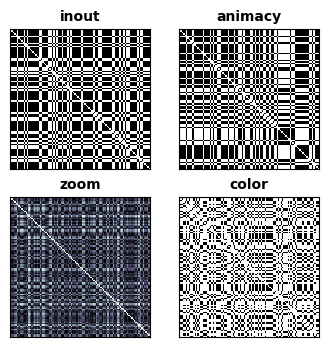

In [ ]:

ds = Dataset.from_df(pandas.concat(subject_dfs))


rdm_list = []
for c in ('animacy', 'in_out', 'distance'):
    model_rdm = calc_rdm_euclidean(
        ds.subset_channel('name', c),
        descriptor='nsd'
    )
    model_rdm.rdm_descriptors['name'] = [c]
    rdm_list.append(model_rdm)
model_rdm = calc_rdm_euclidean(
    ds.subset_channel('name', ['r', 'g', 'b']),
    descriptor='nsd'
)
model_rdm.rdm_descriptors['name'] = ['color']
rdm_list.append(model_rdm)
rdms = concat(rdm_list)
rdms.dissimilarities = numpy.sqrt(rdms.dissimilarities)
fig, _, _ = rsatoolbox.vis.show_rdm(model_rdms, rdm_descriptor='name')
pyplot.show()

## Create rsa models

In [ ]:
model_names = annotation_rdms.rdm_descriptors['name']
models = []
for model_name in model_names:
    model_rdm = annotation_rdms.subset('name', model_name)
    models.append(ModelFixed(model_name, model_rdm))


## Evaluate models

In [ ]:

# Fixed
result_fixed = eval_fixed(models, rdms_condition, method='corr')
print(result_fixed)
plt.close('all')
plt.figure()
fig, _, _ = plot_model_comparison(result_fixed)
plt.savefig(join(plot_path, f'model-comp-fixed_task-{task}_phase-{phase}.png'), dpi=300)
